In [4]:
%pip install tensorflow==2.15

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


# Importing libraries

In [5]:
import tensorflow as tf
import keras
import sklearn
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("scikit-learn:", sklearn.__version__)

TensorFlow: 2.15.0
Keras: 2.15.0
scikit-learn: 1.2.2


In [6]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix

 # Setting up dataset paths

In [7]:
dataset_path = '/kaggle/input/robin-base'
dataset_class = os.listdir(dataset_path)

train_dir = '/kaggle/input/robin-base/train'
val_dir = '/kaggle/input/robin-base/val'
test_dir = '/kaggle/input/robin-base/test'

In [8]:
for split_dir in [train_dir, val_dir, test_dir]:
    print(f"Contents of {split_dir}:")
    for class_dir in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_dir)
        if os.path.isdir(class_path):
            print(f" - Class: {class_dir}, Number of images: {len(os.listdir(class_path))}")

Contents of /kaggle/input/robin-base/train:
 - Class: elektronik, Number of images: 2099
 - Class: logam, Number of images: 2099
 - Class: plastik, Number of images: 2099
 - Class: buah_sayuran, Number of images: 2099
 - Class: makanan, Number of images: 2099
 - Class: daun, Number of images: 2099
 - Class: tekstil, Number of images: 2099
 - Class: medis, Number of images: 2099
 - Class: kaca, Number of images: 2099
 - Class: kertas, Number of images: 2099
Contents of /kaggle/input/robin-base/val:
 - Class: elektronik, Number of images: 600
 - Class: logam, Number of images: 600
 - Class: plastik, Number of images: 600
 - Class: buah_sayuran, Number of images: 600
 - Class: makanan, Number of images: 600
 - Class: daun, Number of images: 600
 - Class: tekstil, Number of images: 600
 - Class: medis, Number of images: 600
 - Class: kaca, Number of images: 600
 - Class: kertas, Number of images: 600
Contents of /kaggle/input/robin-base/test:
 - Class: elektronik, Number of images: 301
 - 

# Previewing sample images

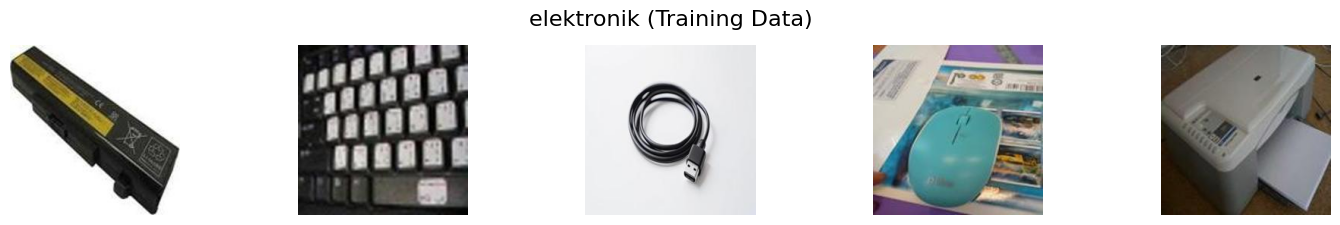

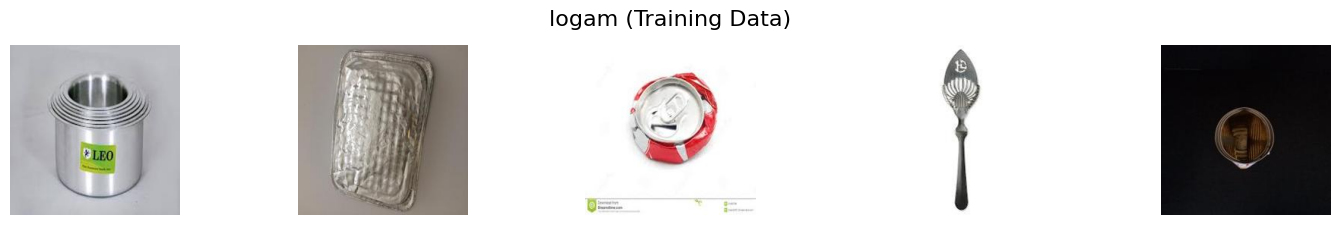

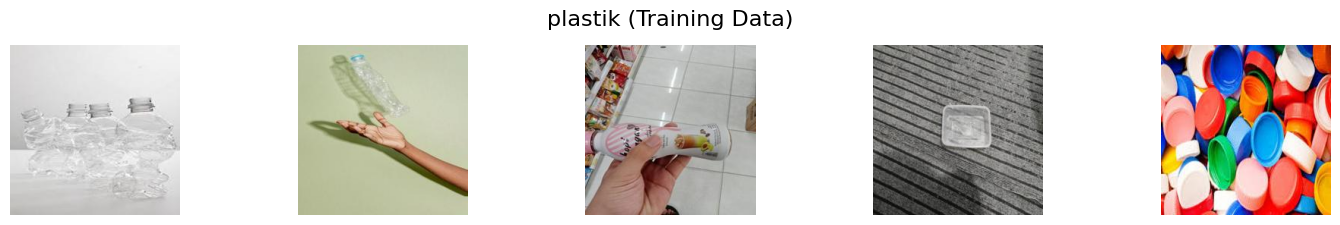

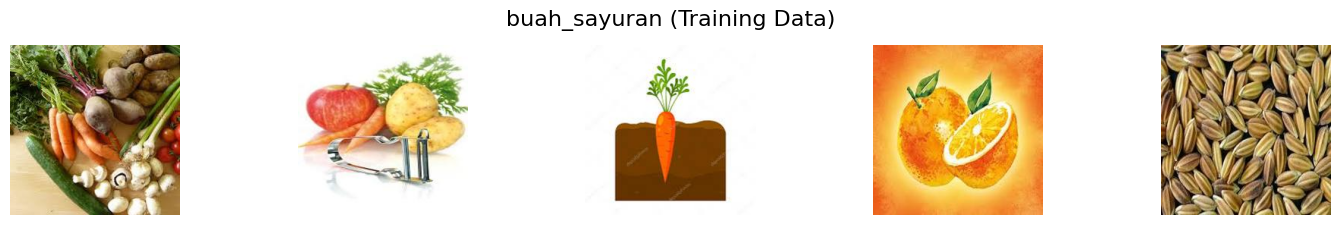

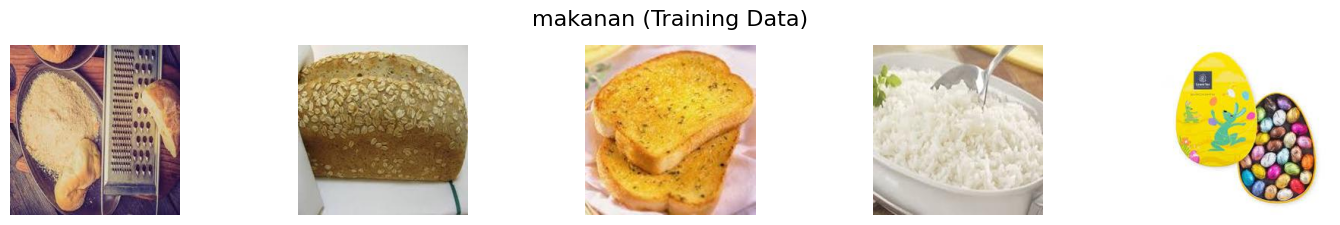

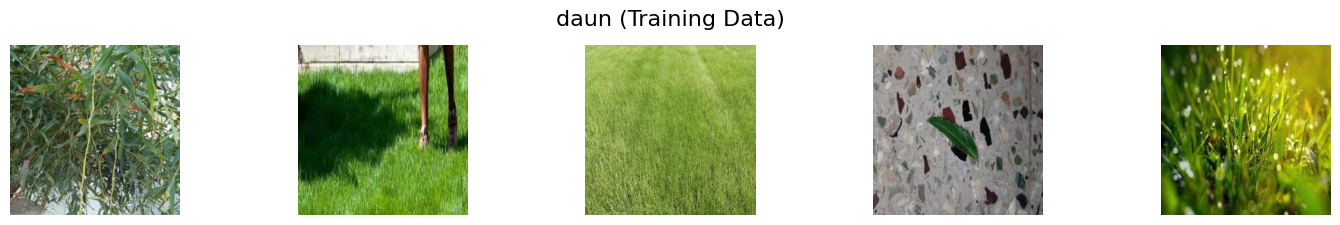

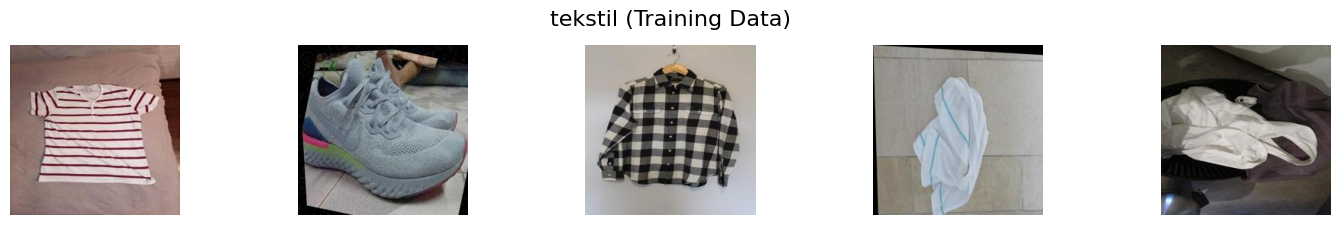

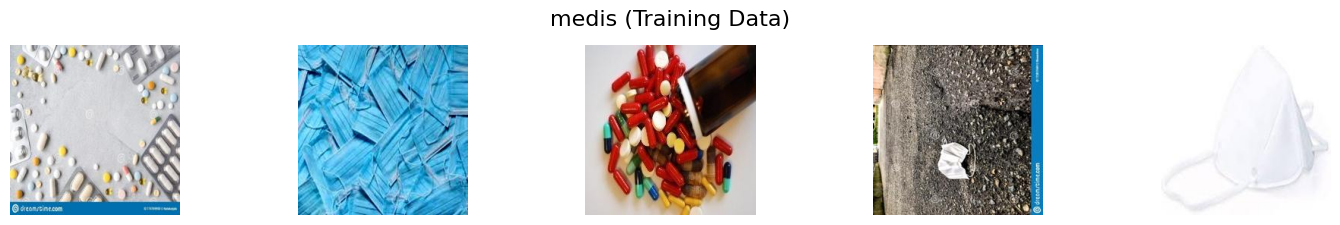

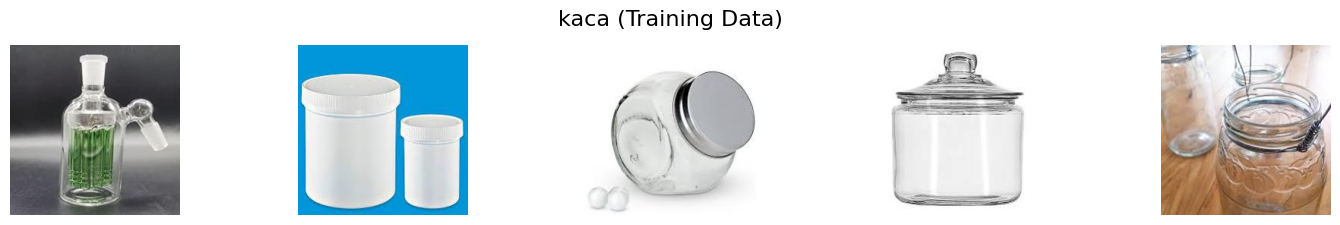

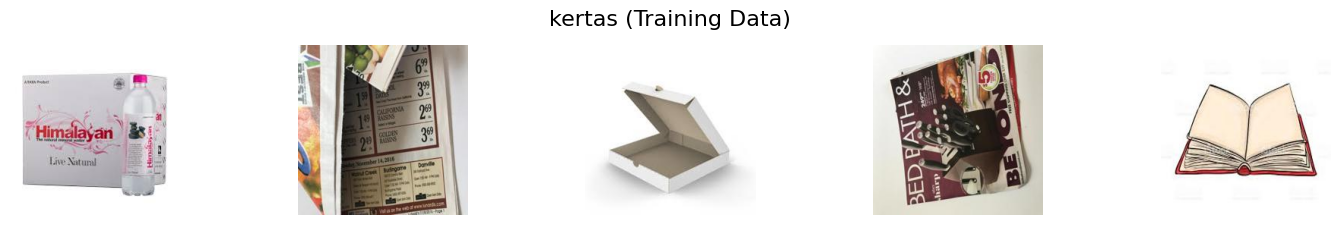

In [9]:
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path) if f.endswith(('jpg', 'jpeg', 'png'))][:5]
        fig, axs = plt.subplots(1, len(image_files), figsize=(15, 2))

        for i, image_file in enumerate(image_files):
            image_path = os.path.join(class_path, image_file)
            with Image.open(image_path) as img:
                axs[i].imshow(img)
                axs[i].axis('off')

        plt.tight_layout()
        fig.suptitle(f"{class_name} (Training Data)", fontsize=16, y=1.1)
        plt.show()

In [10]:
data = []

for class_name in dataset_class:
    for file in os.listdir(os.path.join(dataset_path, class_name)):
        data.append((os.path.join(dataset_path, class_name, file), class_name))

df = pd.DataFrame(data, columns=['filepath', 'label'])
df.head()

filepath label
0    /kaggle/input/robin-base/val/elektronik   val
1         /kaggle/input/robin-base/val/logam   val
2       /kaggle/input/robin-base/val/plastik   val
3  /kaggle/input/robin-base/val/buah_sayuran   val
4       /kaggle/input/robin-base/val/makanan   val

# Image preprocessing and augmentation

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=60,                       # Randomly rotate by up to 60 degrees
    width_shift_range=0.15,                  # Randomly shift horizontally by up to 15% of the width
    height_shift_range=0.15,                 # Randomly shift vertically by up to 15% of the height
    zoom_range=0.20,                         # Randomly zoom in or out by up to 20%
    horizontal_flip=True,                    # Randomly flip horizontally
    vertical_flip=True,                      # Randomly flip vertically
    shear_range=0.05,                        # Apply slight shear transformations
    brightness_range=[0.9, 1.1],             # Vary brightness between 90% to 110%
    channel_shift_range=10,                  # Randomly shift channels
    fill_mode='nearest',                     # Fill in missing pixels with the nearest value
    preprocessing_function=preprocess_input
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [12]:
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 20990 images belonging to 10 classes.
Found 6000 images belonging to 10 classes.
Found 3010 images belonging to 10 classes.


In [13]:
print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")

Number of batches in train_generator: 328
Number of batches in val_generator: 94


In [14]:
train_generator.class_indices

{'buah_sayuran': 0,
 'daun': 1,
 'elektronik': 2,
 'kaca': 3,
 'kertas': 4,
 'logam': 5,
 'makanan': 6,
 'medis': 7,
 'plastik': 8,
 'tekstil': 9}

#  Loading the ResNet50 pre-trained model

In [15]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [16]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [17]:
for i, layer in enumerate(base_model.layers):
    if 140 <= i <= 150:
        print(i, layer.name)

140 conv4_block6_3_bn
141 conv4_block6_add
142 conv4_block6_out
143 conv5_block1_1_conv
144 conv5_block1_1_bn
145 conv5_block1_1_relu
146 conv5_block1_2_conv
147 conv5_block1_2_bn
148 conv5_block1_2_relu
149 conv5_block1_0_conv
150 conv5_block1_3_conv


#  Freezing layers and adding custom layers

In [18]:
for layer in base_model.layers[:143]:
    layer.trainable = False

In [19]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(10, activation='softmax')(x)

robin = Model(inputs=base_model.input, outputs=output)
robin.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
robin.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [21]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001),
    EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1)
]

# Training our model

In [22]:
history = robin.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10


I0000 00:00:1732203049.813821     189 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


328/328 [==============================] - 429s 1s/step - loss: 0.8084 - accuracy: 0.7395 - val_loss: 0.4012 - val_accuracy: 0.8725 - lr: 1.0000e-04
Epoch 2/10
328/328 [==============================] - 316s 962ms/step - loss: 0.4106 - accuracy: 0.8661 - val_loss: 0.3267 - val_accuracy: 0.9018 - lr: 1.0000e-04
Epoch 3/10
328/328 [==============================] - 314s 957ms/step - loss: 0.3040 - accuracy: 0.8976 - val_loss: 0.2970 - val_accuracy: 0.9075 - lr: 1.0000e-04
Epoch 4/10
328/328 [==============================] - 313s 955ms/step - loss: 0.2494 - accuracy: 0.9189 - val_loss: 0.3061 - val_accuracy: 0.9135 - lr: 1.0000e-04
Epoch 5/10
328/328 [==============================] - 316s 962ms/step - loss: 0.2164 - accuracy: 0.9267 - val_loss: 0.3064 - val_accuracy: 0.9155 - lr: 1.0000e-04
Epoch 6/10
328/328 [==============================] - 316s 962ms/step - loss: 0.1248 - accuracy: 0.9579 - val_loss: 0.2796 - val_accuracy: 0.9277 - lr: 5.0000e-05
Epoch 8/10
328/328 [================

In [23]:
def plot_learning_curves(history, start_epoch=5):
    """
    Plot training and validation loss and accuracy curves.

    Parameters:
    - history: Training history (output from the model's fit method).
    - start_epoch: Epoch from which to start plotting. Default is 5 (i.e., plot from epoch 6 onwards).
    """
    
    df = pd.DataFrame(history.history)
    df = df.iloc[start_epoch-1:]
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='royalblue', label='Train Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='royalblue', label='Train Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')

    plt.show()

# Learning curves and model performance

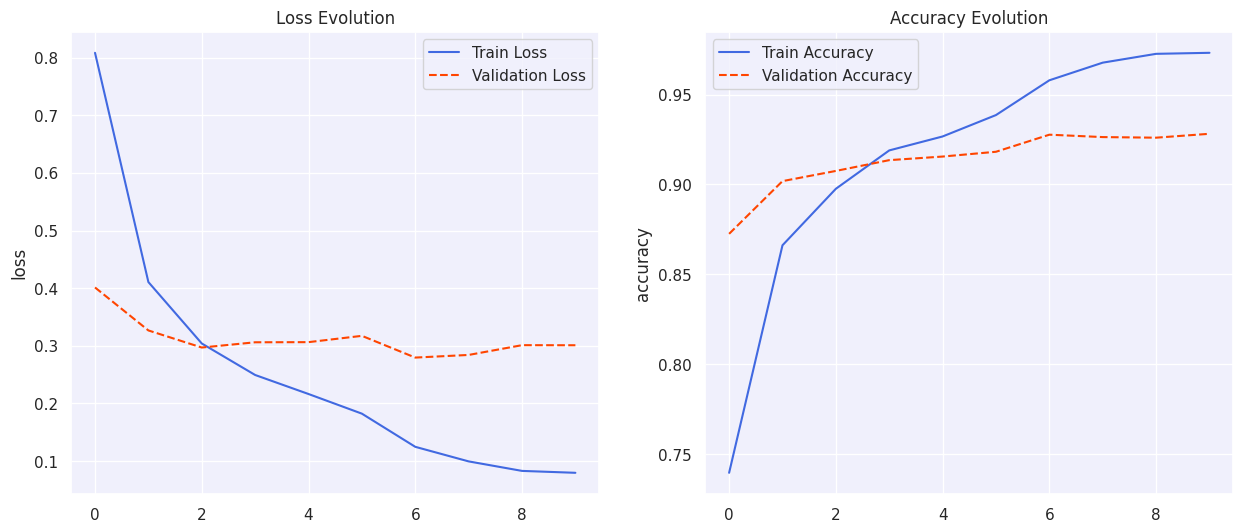

In [24]:
plot_learning_curves(history, start_epoch=1)

In [25]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.
    
    Returns:
    - report: Classification report as a string.
    """
    
    true_labels = val_generator.classes
    class_labels = list(val_generator.class_indices.keys()) 
    predictions = model.predict(val_generator, steps=len(val_generator))
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = val_generator.classes
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')
    
    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)
    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

48/48 [==============================] - 25s 514ms/step
              precision    recall  f1-score   support

buah_sayuran       0.87      0.90      0.89       301
        daun       0.96      0.98      0.97       301
  elektronik       0.97      0.97      0.97       301
        kaca       0.90      0.91      0.90       301
      kertas       0.95      0.93      0.94       301
       logam       0.92      0.91      0.92       301
     makanan       0.91      0.93      0.92       301
       medis       0.93      0.93      0.93       301
     plastik       0.89      0.85      0.87       301
     tekstil       0.98      0.98      0.98       301

    accuracy                           0.93      3010
   macro avg       0.93      0.93      0.93      3010
weighted avg       0.93      0.93      0.93      3010





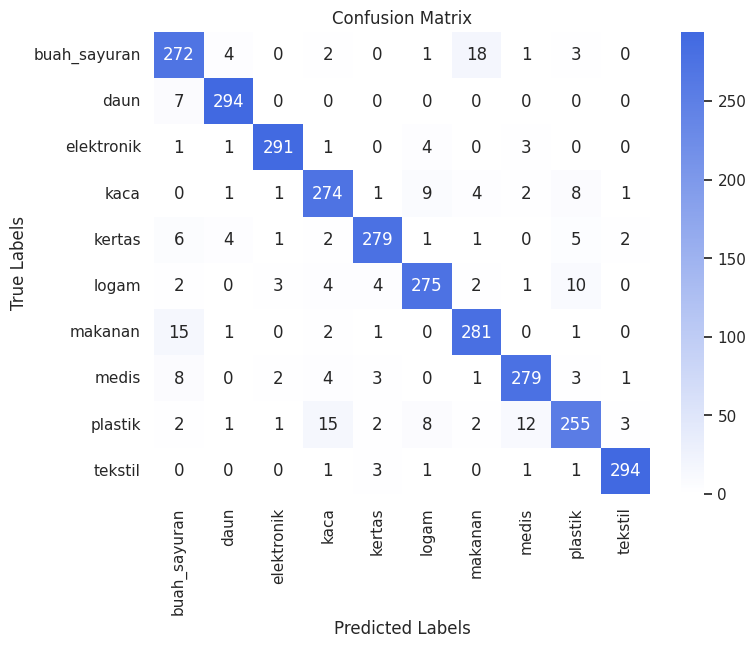

In [27]:
class_labels = list(test_generator.class_indices.keys())
evaluate_model_performance(robin, test_generator, class_labels)

# Testing the model

In [54]:
def plot_random_predictions(model, test_dir, class_labels, num_images=9, seed=None):
    """
    Plot a grid of random predictions for test images from different class folders.

    Parameters:
    - model: The trained model.
    - test_dir: Path to the test directory.
    - class_labels: List of class names.
    - num_images: Number of images to display (default is 9 for a 3x3 grid).
    - seed: Random seed for reproducibility (default is None for different random selections).
    """

    if seed is not None:
        np.random.seed(seed)

    image_paths = []
    image_labels = []
    for class_name in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_name)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_paths.append(os.path.join(class_path, image_file))
                image_labels.append(class_name)

    selected_indices = np.random.choice(len(image_paths), num_images, replace=False)

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, ax in enumerate(axes.flat):
        if i >= len(selected_indices):
            break
        idx = selected_indices[i]

        img_path = image_paths[idx]
        img = Image.open(img_path).resize((224, 224))
        img_array = np.array(img)
        preprocessed_img = preprocess_input(img_array.astype('float32'))

        prediction = model.predict(np.expand_dims(preprocessed_img, axis=0))
        predicted_label = class_labels[np.argmax(prediction)]
        true_label = image_labels[idx]

        ax.imshow(img)
        ax.axis('off')
        color = 'green' if true_label == predicted_label else 'red'
        ax.set_title(f"True: {true_label}\nPred: {predicted_label}", color=color)

    plt.show()


In [72]:
class_labels = list(test_generator.class_indices.keys())

2/2 [==============================] - 0s 59ms/step


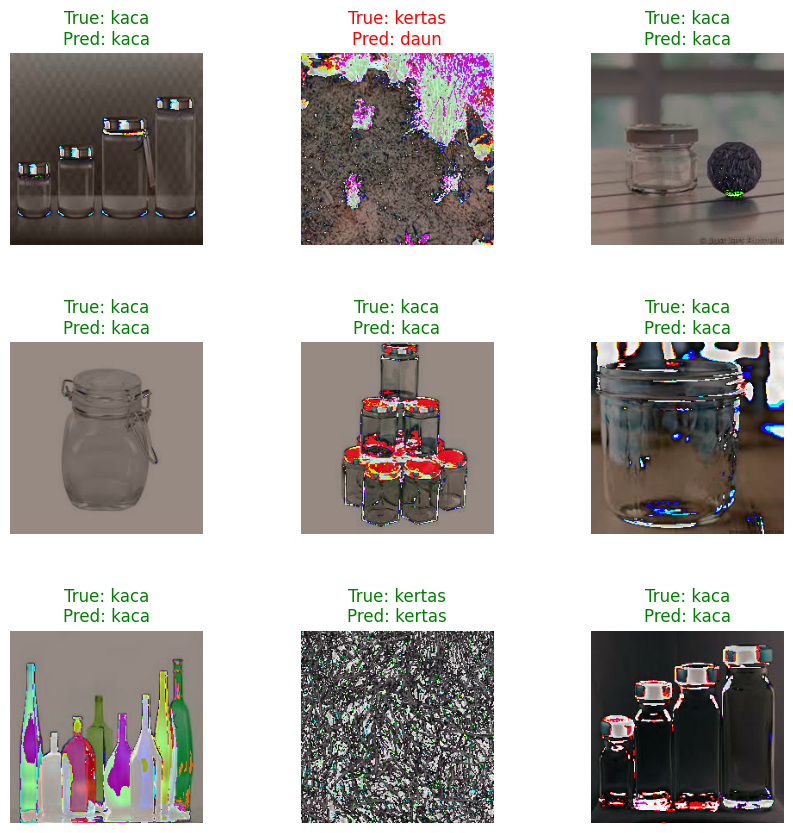

In [73]:
plot_predictions(robin, test_generator, class_labels, seed=8)

2/2 [==============================] - 0s 55ms/step


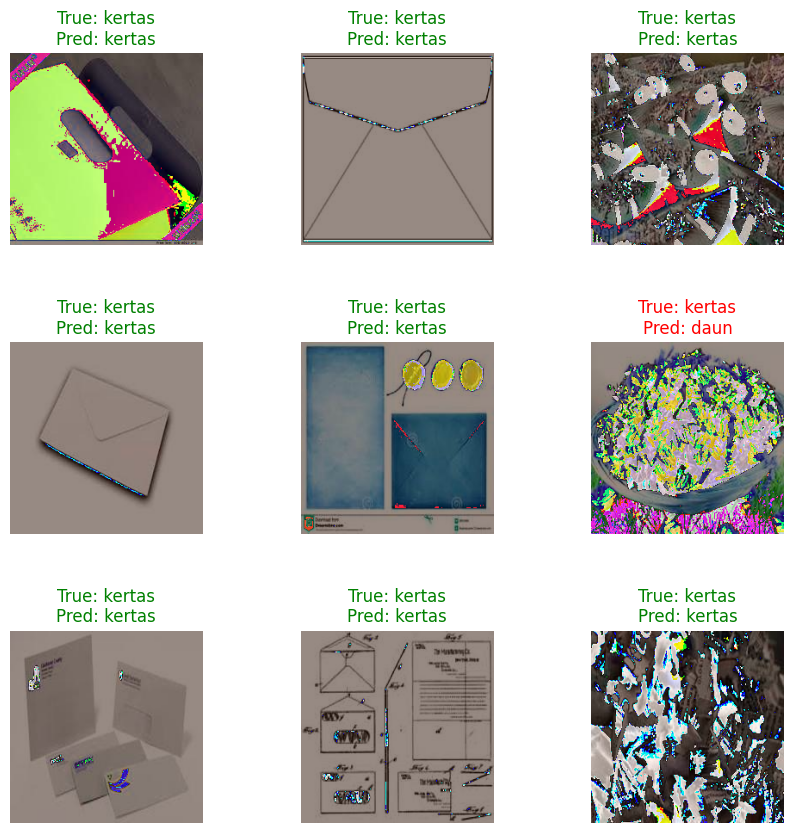

In [74]:
plot_predictions(robin, test_generator, class_labels, seed=16)

2/2 [==============================] - 0s 54ms/step


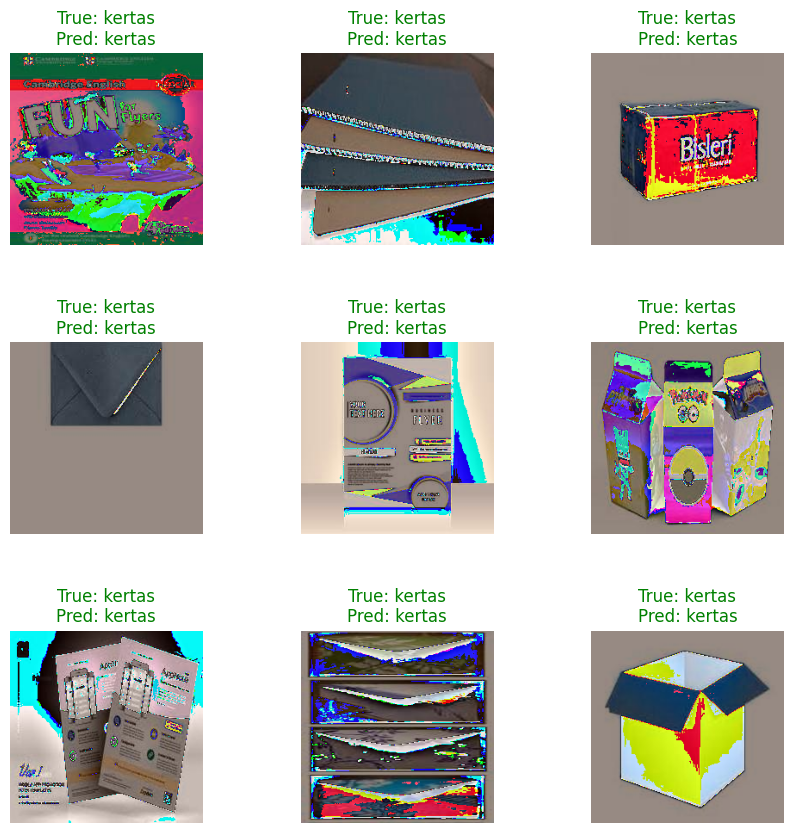

In [75]:
plot_predictions(robin, test_generator, class_labels, seed=32)

2/2 [==============================] - 0s 54ms/step


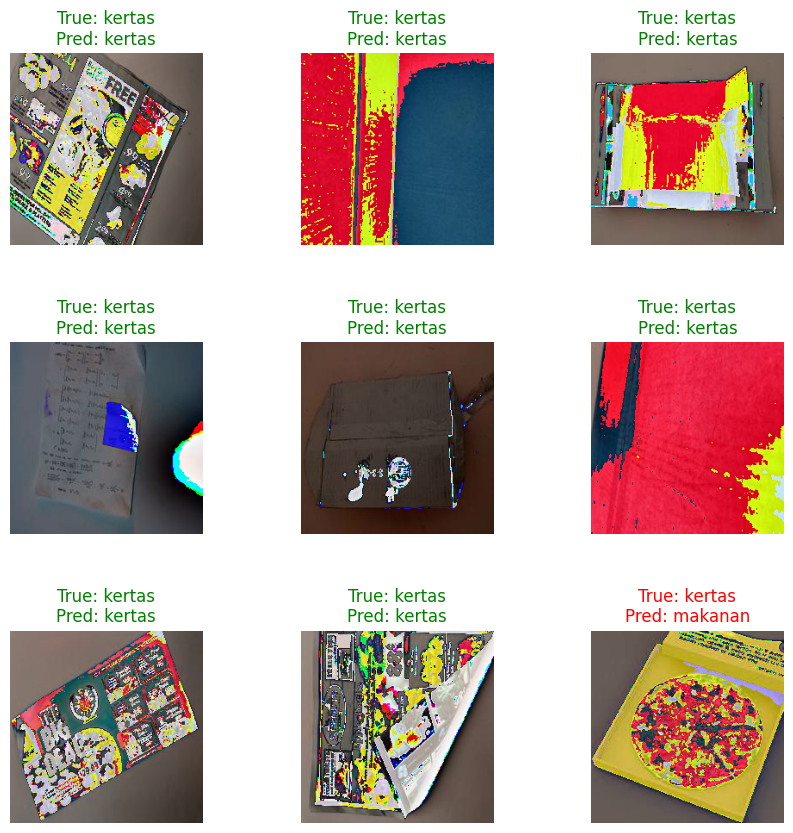

In [76]:
plot_predictions(robin, test_generator, class_labels, seed=64)

2/2 [==============================] - 0s 58ms/step


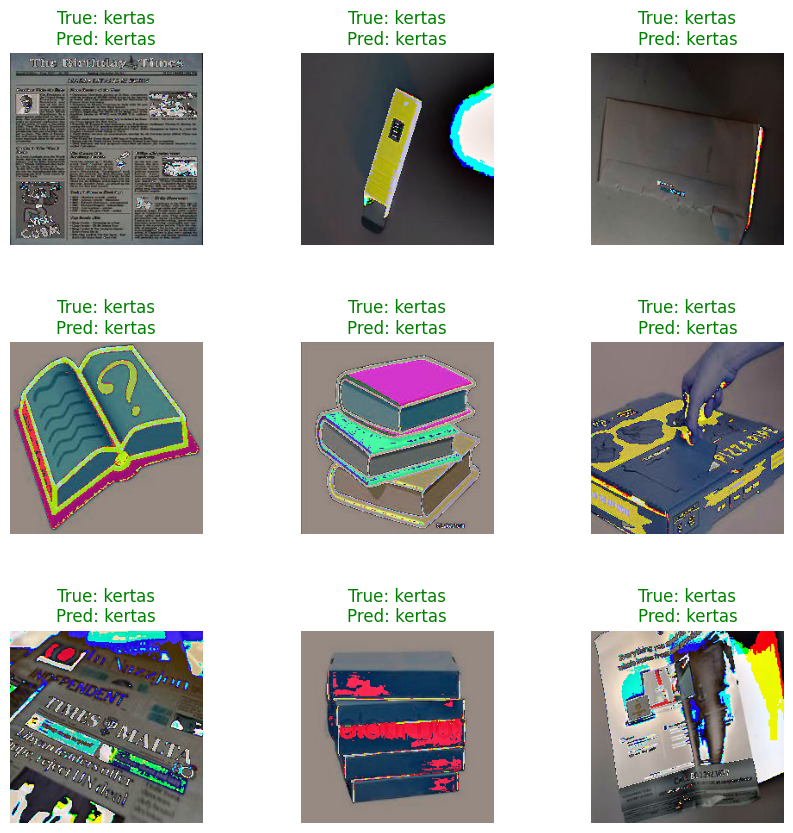

In [77]:
plot_predictions(robin, test_generator, class_labels, seed=128)

2/2 [==============================] - 0s 55ms/step


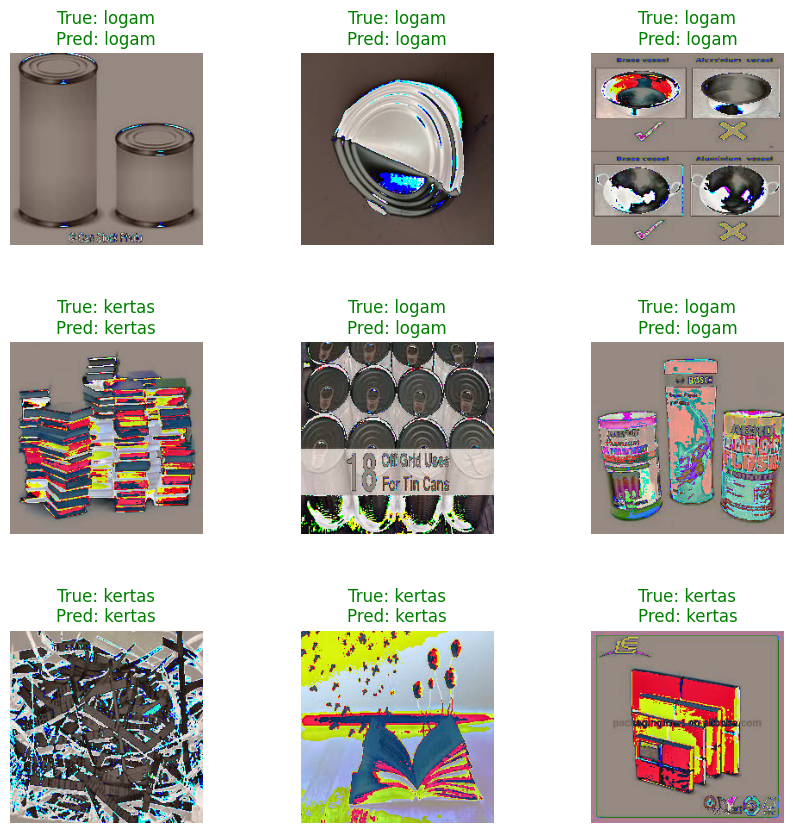

In [78]:
plot_predictions(robin, test_generator, class_labels, seed=256)

In [79]:
model_save_path = "./robin.keras"
robin.save(model_save_path)
print(f"Saved to {model_save_path}")

Saved to ./robin.keras
